Dataset shape: (1025, 13)

--- 1. Correlation Matrix ---


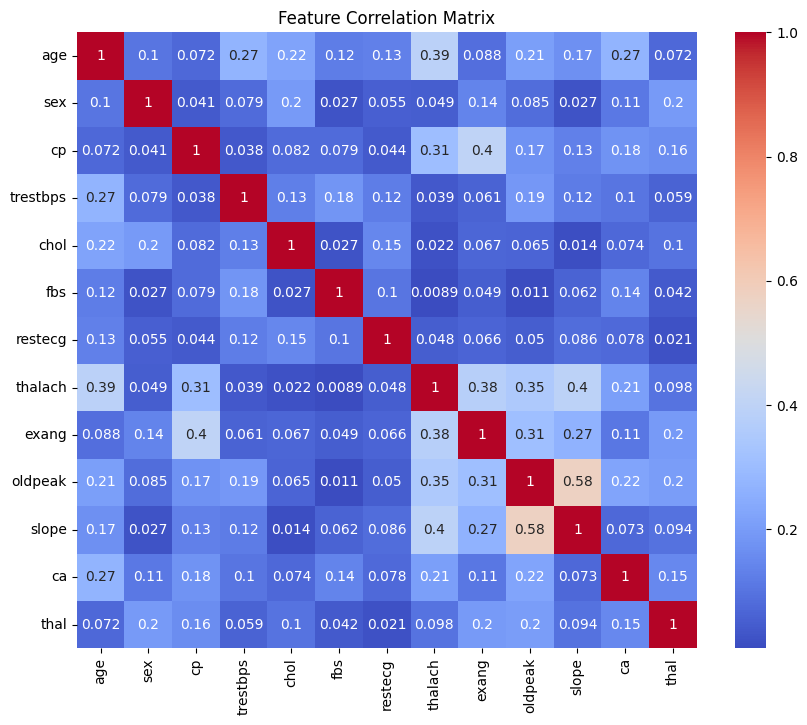

Features to drop due to high correlation (>0.85): []

--- 2. Univariate Selection (Mutual Information) ---
Top 5 Features (Univariate): ['cp', 'chol', 'thalach', 'oldpeak', 'thal']
Accuracy with Top-5 Univariate features: 0.8156
Accuracy with all features: 0.8585

--- 3. Recursive Feature Elimination (RFE) ---
Top 5 Features (RFE): ['sex', 'cp', 'thalach', 'oldpeak', 'ca']
Accuracy with RFE features: 0.8059

--- 4. RFECV (Automatic Number of Features) ---
Optimal number of features: 12
Selected Features (RFECV): ['age', 'sex', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Accuracy with RFECV features: 0.8585
Best Cross-Validation Score: 0.8478


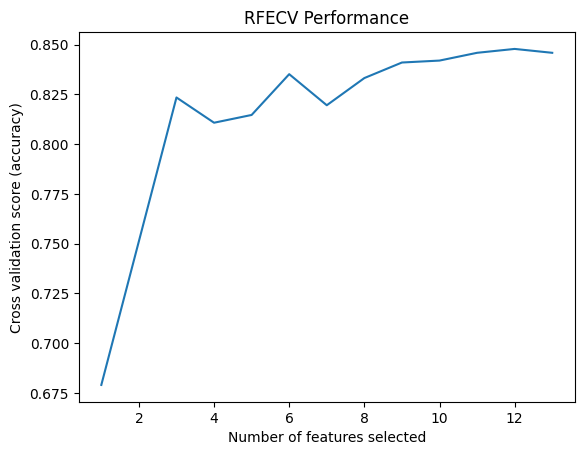


--- 5. Embedded Method (Lasso L1) ---
Features selected by Lasso (non-zero weights):
['age', 'sex', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Accuracy with Lasso L1: 0.8449
Lasso Coefficients:
 age        -0.059491
sex        -0.651373
cp          0.720967
trestbps   -0.214001
chol       -0.165820
restecg     0.138685
thalach     0.430719
exang      -0.402547
oldpeak    -0.565493
slope       0.256392
ca         -0.632488
thal       -0.447367
dtype: float64

--- 6. PCA Analysis ---
Number of PCA components to explain 95% variance: 12
Number of original features: 13


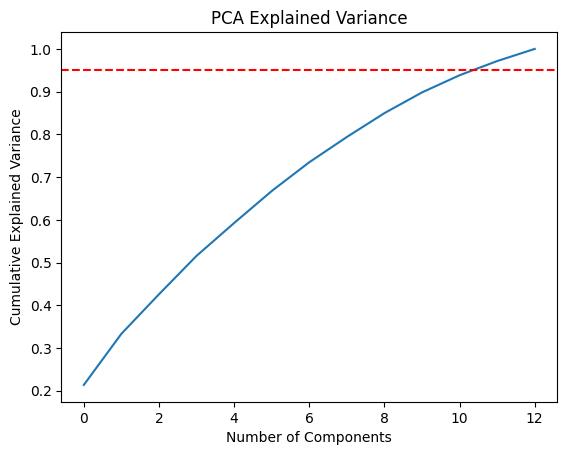

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE, RFECV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# 1. LOAD THE DATA
heart_data = pd.read_csv('heart.csv')
X = heart_data.drop(columns=['target']) 
y = heart_data['target']

X = pd.get_dummies(X, drop_first=True)
feature_names = X.columns
X_std = StandardScaler().fit_transform(X)

print(f"Dataset shape: {X.shape}")

# ==========================================================
# PART 1: CORRELATION FILTERING (Exploratory)
# ==========================================================
print("\n--- 1. Correlation Matrix ---")
plt.figure(figsize=(10, 8))
corr_matrix = pd.DataFrame(X_std, columns=feature_names).corr().abs()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Feature Correlation Matrix")
plt.show()

# Find redundant features (Correlation > 0.85)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print(f"Features to drop due to high correlation (>0.85): {to_drop}")

# ==========================================================
# PART 2: UNIVARIATE SELECTION (Mutual Information)
# ==========================================================
print("\n--- 2. Univariate Selection (Mutual Information) ---")
# Select top 5 features
selector = SelectKBest(mutual_info_classif, k=5)
X_univ = selector.fit_transform(X_std, y)
selected_indices = selector.get_support(indices=True)
print(f"Top 5 Features (Univariate): {feature_names[selected_indices].tolist()}")

# Train a simple model on these 5 features
model = LogisticRegression()
model.fit(X_univ, y)
acc = model.score(X_univ, y)
print(f"Accuracy with Top-5 Univariate features: {acc:.4f}")
model.fit(X_std, y)
acc = model.score(X_std, y)
print(f"Accuracy with all features: {acc:.4f}")

# ==========================================================
# PART 3 & 4: RFE and RFECV
# ==========================================================
print("\n--- 3. Recursive Feature Elimination (RFE) ---")
estimator = LogisticRegression(max_iter=1000)
rfe = RFE(estimator, n_features_to_select=5, step=1)
rfe.fit(X_std, y)
rfe_features = feature_names[rfe.support_]
acc_rfe = rfe.score(X_std, y)

print(f"Top 5 Features (RFE): {rfe_features.tolist()}")
print(f"Accuracy with RFE features: {acc_rfe:.4f}")

print("\n--- 4. RFECV (Automatic Number of Features) ---")
# Uses Cross-Validation to find optimal number
rfecv = RFECV(estimator=estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_std, y)

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected Features (RFECV): {feature_names[rfecv.support_].tolist()}")

acc_rfecv = rfecv.score(X_std, y)
print(f"Accuracy with RFECV features: {acc_rfecv:.4f}")

print(f"Best Cross-Validation Score: {max(rfecv.cv_results_['mean_test_score']):.4f}")

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title("RFECV Performance")
plt.show()

# ==========================================================
# PART 5: EMBEDDED METHOD (Lasso / L1)
# ==========================================================
print("\n--- 5. Embedded Method (Lasso L1) ---")
# C=0.1 increases regularization (stronger penalty -> more zeros)
lasso = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=42)
lasso.fit(X_std, y)
lasso_acc = lasso.score(X_std, y)

# Check which coefficients are non-zero
lasso_coefs = pd.Series(lasso.coef_[0], index=feature_names)
important_feats = lasso_coefs[lasso_coefs != 0]
print(f"Features selected by Lasso (non-zero weights):\n{important_feats.index.tolist()}")
print(f"Accuracy with Lasso L1: {lasso_acc:.4f}")
print("Lasso Coefficients:\n", important_feats)

# ==========================================================
# PART 6: PCA COMPARISON
# ==========================================================
print("\n--- 6. PCA Analysis ---")
pca = PCA().fit(X_std)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find how many components explain 95% variance
n_components_95 = np.argmax(explained_variance >= 0.95) + 1
print(f"Number of PCA components to explain 95% variance: {n_components_95}")
print(f"Number of original features: {X.shape[1]}")

plt.figure()
plt.plot(explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title("PCA Explained Variance")
plt.show()